In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans  ### NÃO SUPERVISIONADA
from sklearn.decomposition import PCA   ### NÃO SUPERVISIONADA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score  ### AVALIAR ALGORITIMOS DE CLUSTERIZAÇÃO
from sklearn.preprocessing import LabelEncoder
import warnings
import joblib
warnings.filterwarnings("ignore")

In [ ]:
## A PARTIR DA ANÁLISE REALIZADA ANTERIORMENTE, OS DADOS AJUSTADOS SERÃO APLICADOS AOS ALGORITIMOS DE CLUSTERIZAÇÃO.

##  APÓS O TREINAMENTO DO ALGORITIMO, OS DADOS ORIGINAIS, SEM OS SALES = 0 ou MEAN_PRICE VAZIOS, SERÃO APLICADOS PARA PREVISÃO, PORTANTO PRATICAMENTE TODA BASE SERÁ CONSIDERADA PARA FUTURA PREVISÃO.

## PARA QUE OS DADOS CONTINUEM COM SEUS DADOS ORIGINAIS FOI NECESSÁRIO DIVIDIR EM TRÊS ELEMENTOS, POIS O LABEL_ENCODER POSSUI UM "BUG" QUE APLICA O LABEL NAS CATEGORIAS, MESMO EM ELEMENTOS DIFERENTES.

dados_frame = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')

dados_frame_completo = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')

dados_frame_completo_carregar_labels = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')


In [ ]:
### CRIANDO LABEL PARA OS CATEGÓRICOS, UTILIZANDO O LABEL_ENCODER.

label_encoder = LabelEncoder()

## ESTES SÃO OS DADOS QUE SERÃO MODIFICADOS PARA O TREINAMENTO

## A COLUNA "YEAR_MONTH" FOI TRANSFORMADA PARA DATETIME E REGION SERÁ TRANSFORMADO EM NUMÉRICO

## A COLUNA SOMA TAMBÉM FOI ADICIONADA PARA FUTURAMENTE SER UTILIZADA

dados_frame['year_month'] = pd.to_datetime(dados_frame['year_month'])
dados_frame['region'] = label_encoder.fit_transform(dados_frame['region'])
dados_frame['SOMA'] = dados_frame['sales'] * dados_frame['mean_price']
dados_frame = dados_frame[dados_frame['year_month'] != '2011-01']

## ESTES SÃO OS DADOS QUE SERÃO UTILIZADOS PARA O PREDICT

dados_frame_completo = dados_frame_completo[dados_frame_completo['year_month'] != '2011-01']
dados_frame_completo['year_month'] = pd.to_datetime(dados_frame_completo['year_month'])
dados_frame_completo['SOMA'] = dados_frame_completo['sales'] * dados_frame_completo['mean_price']
dados_frame_completo['region'] = label_encoder.fit_transform(dados_frame_completo['region'])

## ESTES SÃO OS DADOS QUE SERÃO UTILIZADOS PARA CARREGAR AS LABELS DAS CATEGORIAS

dados_frame_completo_carregar_labels = dados_frame_completo_carregar_labels[dados_frame_completo_carregar_labels['year_month'] != '2011-01']
dados_frame_completo_carregar_labels['year_month'] = pd.to_datetime(dados_frame_completo_carregar_labels['year_month'])
dados_frame_completo_carregar_labels['SOMA'] = dados_frame_completo_carregar_labels['sales'] * dados_frame_completo_carregar_labels['mean_price']

In [ ]:
### RETIRANDO DADOS SEM VENDAS E AQUELES COM MÉDIA DE PREÇO SEM DADOS

dados_frame = dados_frame[dados_frame['sales'] != 0]
dados_frame = dados_frame[~(dados_frame['mean_price'].isna() & (dados_frame['sales'] > 0))]
dados_frame_completo = dados_frame_completo[dados_frame_completo['sales'] != 0]
dados_frame_completo = dados_frame_completo[~(dados_frame_completo['mean_price'].isna() & (dados_frame_completo['sales'] > 0))]
dados_frame_completo_carregar_labels = dados_frame_completo_carregar_labels[dados_frame_completo_carregar_labels['sales'] != 0]
dados_frame_completo_carregar_labels = dados_frame_completo_carregar_labels[~(dados_frame_completo_carregar_labels['mean_price'].isna() & (dados_frame_completo_carregar_labels['sales'] > 0))]

In [ ]:
### RETIRANDO OUTLIERS DO PRIMEIRO E QUARTO QUARTIS

Q1 = dados_frame['SOMA'].quantile(0.25)
Q3 = dados_frame['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.0 * IQR
limite_superior = Q3 + 1.0 * IQR

dados_frame = dados_frame[(dados_frame['SOMA'] >= limite_inferior) & (dados_frame['SOMA'] <= limite_superior)]



In [ ]:
### PADRONIZANDO OS DADOS

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dados_frame = scaler.fit_transform(dados_frame[['sales', 'mean_price', 'region']])

dados_frame_completo = scaler.fit_transform(dados_frame_completo[['sales', 'mean_price', 'region']])

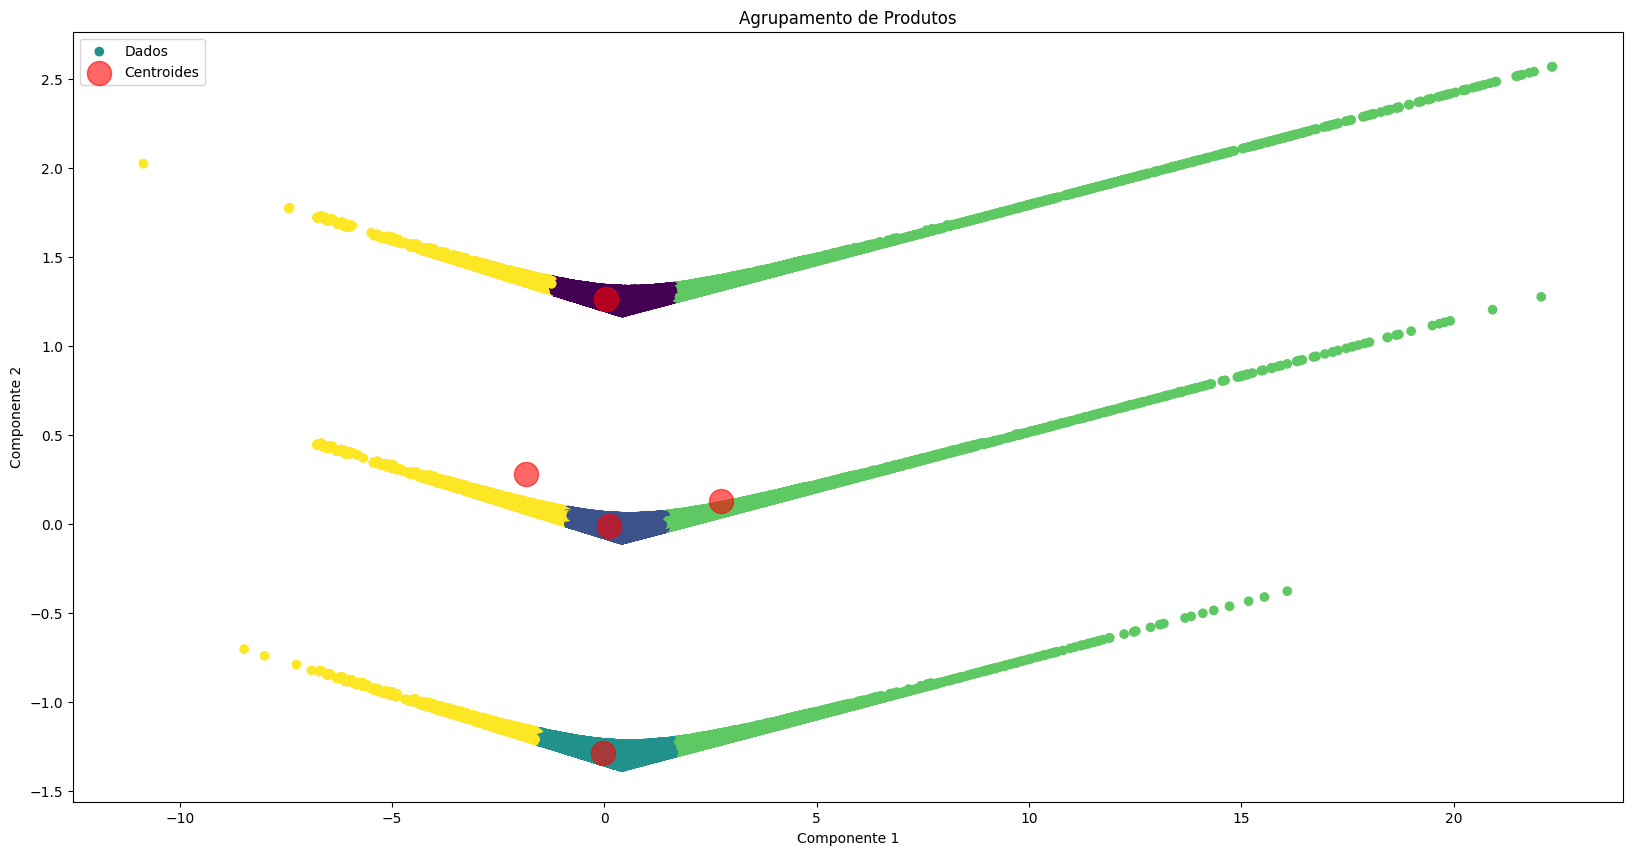

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca2 = PCA(n_components=2)

# Utilizando o PCA em dados já normalizados
componentes_principais = pca.fit_transform(dados_frame)
componentes_principais = pd.DataFrame(componentes_principais, columns=['Componente 1', 'Componente 2'])

componentes_principais2 = pca2.fit_transform(dados_frame_completo)
componentes_principais2 = pd.DataFrame(componentes_principais2, columns=['Componente 1', 'Componente 2'])

# Criar DataFrame
df = pd.DataFrame(componentes_principais)

df2 = pd.DataFrame(componentes_principais2)

# Treinar o modelo KMeans
kmeans_TREINADO = KMeans(n_clusters=5, random_state=100, n_init=20, max_iter=600)
kmeans_TREINADO.fit(df)
df['Grupo'] = kmeans_TREINADO.predict(df)
dados_frame_completo_carregar_labels['Grupo'] = kmeans_TREINADO.predict(df2)



# Plotar os resultados
plt.figure(figsize=(20, 10))
scatter = plt.scatter(df['Componente 1'], df['Componente 2'], c=df['Grupo'], cmap='viridis', label='Dados')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Agrupamento de Produtos')

# Adicionar centroides
centroids = kmeans_TREINADO.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, alpha=0.6, label='Centroides')

# Adicionar legenda
plt.legend(*scatter.legend_elements(), title="Grupos")
plt.legend()

plt.show()


In [ ]:
joblib.dump(kmeans_TREINADO, 'kmeans_treinado.pkl')


['kmeans_treinado.pkl']

In [ ]:
dados_frame_completo_carregar_labels

,year_month,id,item,category,department,store,store_code,region,sales,mean_price,SOMA,Grupo
30520,2011-02-01,ACCESORIES_1_004_BOS_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,43,5.7722,248.2046,2
30521,2011-02-01,ACCESORIES_1_004_BOS_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Roxbury,BOS_2,Boston,70,5.7722,404.0540,2
30524,2011-02-01,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,New York,127,5.7722,733.0694,1
30525,2011-02-01,ACCESORIES_1_004_NYC_3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,New York,12,5.7722,69.2664,1
30526,2011-02-01,ACCESORIES_1_004_NYC_4,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Brooklyn,NYC_4,New York,27,5.7722,155.8494,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1951355,2016-04-01,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,133,1.2000,159.6000,4
1951356,2016-04-01,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Brooklyn,NYC_4,New York,38,1.2000,45.6000,1
1951357,2016-04-01,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Midtown_Village,PHI_1,Philadelphia,75,1.2000,90.0000,0
1951358,2016-04-01,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,Yorktown,PHI_2,Philadelphia,66,1.2000,79.2000,0


In [ ]:
dados_frame_completo_carregar_labels['Cluster'] = df2['Grupo']

Text(0.5, 1.0, 'Curva de Elbow')

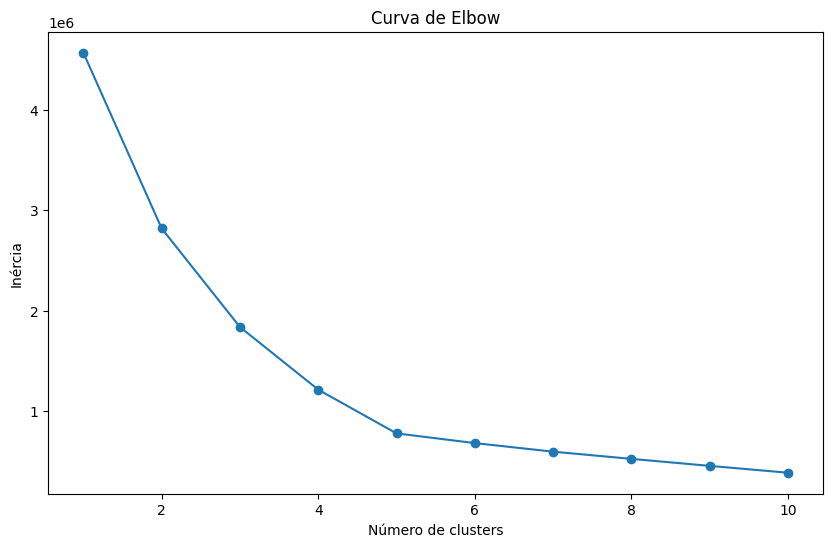

In [ ]:
# Gerar curva de elbow
inercia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=20, max_iter=600)
    kmeans.fit(df)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inercia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Curva de Elbow')


In [ ]:
# VERIFICANDO O SILHOUETTE_SCORE

# COMO EXIGE MUITA CAPACIDADE, IREI UTILIZAR 10% DA BASE DE DADOS PARA VERIFICAR PRELIMINARMENTE. UTILIZAREI O TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(df, train_size=0.1, random_state=42)

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_train, X_train['Grupo'])

print(f"A pontuação de silhueta média é: {silhouette_avg}")


A pontuação de silhueta média é: 0.6118789986765507


A pontuação de silhueta média é: 0.5773699449617911


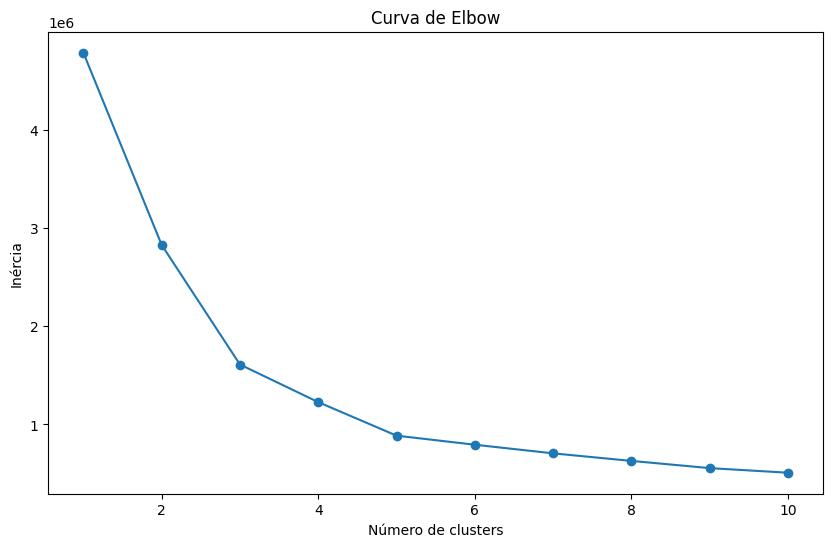

In [ ]:
## TESTANDO COM MAIS CATEGORIAS NO TREINAMENTO

dados_frame = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')
dados_frame['year_month'] = pd.to_datetime(dados_frame['year_month'])
dados_frame['region'] = label_encoder.fit_transform(dados_frame['region'])
dados_frame['store_code'] = label_encoder.fit_transform(dados_frame['store_code'])
dados_frame['SOMA'] = dados_frame['sales'] * dados_frame['mean_price']
dados_frame = dados_frame[dados_frame['year_month'] != '2011-01']

dados_frame = dados_frame[dados_frame['sales'] != 0]
dados_frame = dados_frame[~(dados_frame['mean_price'].isna() & (dados_frame['sales'] > 0))]

Q1 = dados_frame['SOMA'].quantile(0.25)
Q3 = dados_frame['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.0 * IQR
limite_superior = Q3 + 1.0 * IQR

dados_frame = dados_frame[(dados_frame['SOMA'] >= limite_inferior) & (dados_frame['SOMA'] <= limite_superior)]

dados_frame1 = scaler.fit_transform(dados_frame[['sales', 'mean_price', 'region']])
dados_frame2 = scaler.fit_transform(dados_frame[['sales', 'mean_price', 'region', 'SOMA']])
dados_frame3 = scaler.fit_transform(dados_frame[['sales', 'mean_price', 'region', 'store' 'SOMA']])
dados_frame4 = scaler.fit_transform(dados_frame[['sales', 'mean_price', 'region', 'store']])

pca = PCA(n_components=2)

# Utilizando o PCA em dados já normalizados
componentes_principais = pca.fit_transform(dados_frame)
componentes_principais = pd.DataFrame(componentes_principais, columns=['Componente 1', 'Componente 2'])


# Criar DataFrame
df = pd.DataFrame(componentes_principais)


# Treinar o modelo KMeans
kmeans_TREINADO2 = KMeans(n_clusters=5, random_state=100, n_init=20, max_iter=600)
kmeans_TREINADO2.fit(df)
df['Grupo'] = kmeans_TREINADO2.predict(df)


inercia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=20, max_iter=600)
    kmeans.fit(df)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inercia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inércia')
plt.title('Curva de Elbow')


X_train, X_test= train_test_split(df, train_size=0.1, random_state=42)

from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_train, X_train['Grupo'])

print(f"A pontuação de silhueta média é: {silhouette_avg}")



In [ ]:
dados_frame = pd.read_csv('https://relacoesinstitucionais.com.br/Fotos/Temp/base_mensal.csv')
dados_frame['year_month'] = pd.to_datetime(dados_frame['year_month'])
dados_frame['region'] = label_encoder.fit_transform(dados_frame['region'])
dados_frame['store_code'] = label_encoder.fit_transform(dados_frame['store_code'])
dados_frame['SOMA'] = dados_frame['sales'] * dados_frame['mean_price']
dados_frame = dados_frame[dados_frame['year_month'] != '2011-01']

dados_frame = dados_frame[dados_frame['sales'] != 0]
dados_frame = dados_frame[~(dados_frame['mean_price'].isna() & (dados_frame['sales'] > 0))]

Q1 = dados_frame['SOMA'].quantile(0.25)
Q3 = dados_frame['SOMA'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.0 * IQR
limite_superior = Q3 + 1.0 * IQR

dados_frame = dados_frame[(dados_frame['SOMA'] >= limite_inferior) & (dados_frame['SOMA'] <= limite_superior)]


dataframes = [
    dados_frame[['sales', 'mean_price', 'region']],
    dados_frame[['sales', 'mean_price', 'region', 'SOMA']],
    dados_frame[['sales', 'mean_price', 'region', 'store_code', 'SOMA']],
    dados_frame[['sales', 'mean_price', 'region', 'store_code']]
]

# Inicializando o scaler e PCA
scaler = StandardScaler()
pca = PCA(n_components=2)

# Iterando sobre cada dataframe
for i, df in enumerate(dataframes):
    # Normalizando os dados
    df_scaled = scaler.fit_transform(df)

    # Aplicando PCA
    componentes_principais = pca.fit_transform(df_scaled)
    componentes_principais = pd.DataFrame(componentes_principais, columns=['Componente 1', 'Componente 2'])

    # Treinando o modelo KMeans
    kmeans_TREINADO2 = KMeans(n_clusters=5, random_state=100, n_init=20, max_iter=600)
    kmeans_TREINADO2.fit(componentes_principais)
    componentes_principais['Grupo'] = kmeans_TREINADO2.predict(componentes_principais)



    # Dividindo os dados em conjuntos de treino e teste
    X_train, X_test = train_test_split(componentes_principais, train_size=0.05, random_state=42)

    # Calculando a pontuação de silhueta média
    silhouette_avg = silhouette_score(X_train, X_train['Grupo'])

    print(f"A pontuação de silhueta média para DataFrame {i+1} é: {silhouette_avg}")

A pontuação de silhueta média para DataFrame 1 é: 0.6111918144013069
A pontuação de silhueta média para DataFrame 2 é: 0.5765435229533876
A pontuação de silhueta média para DataFrame 3 é: 0.6132806743658685
A pontuação de silhueta média para DataFrame 4 é: 0.6207109823221693


In [ ]:
# DEFINITIVO

pca2 = PCA(n_components=2)

componentes_principais2 = pca2.fit_transform(dados_frame_completo)
componentes_principais2 = pd.DataFrame(componentes_principais2, columns=['Componente 1', 'Componente 2'])

# Criar DataFrame

df2 = pd.DataFrame(componentes_principais2)

dados_frame_completo_carregar_labels['Grupo'] = kmeans_TREINADO.predict(df2)